# TODO
- edit calculate beta to get it right
- cubic spline interpolation for GDP data


# Deliverables

- variance-covariance matrix, weights, and avg. returns
- 5 stock betas in csv
- 5 stock daily returns in csv
- inflation, GDP, employment rate, market risk premium
- correlation matrix between economic factors

### Other
 - add frequency parameter to pull data
 - make linear regression more explicit so we can see the linear transformation happening
 - use cubic splines to interpolate monthly GDP numbers - a linear algebra problem
 - find beta of portfolio

In [1]:
%matplotlib inline
import pandas_datareader.data as web
import datetime    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d

def calculate_return(seriesArr):
    return (seriesArr / seriesArr.shift(1)) -1

def get_weighted_portfolio_returns(stock_returns, weight_vector):
    return stock_returns.dot(weight_vector)
    
def get_returns(data):
    """
    Description: returns a matrix dataframe of all stock returns
    Parameters:
    ==========
    data - DataFrame:
    
    Return:
    ======
    """
    if type(data) == pd.DataFrame:
        li = []
        for ticker in data.columns:
            stock_return = pd.DataFrame(calculate_return(data[ticker]))
            li.append(stock_return)
        temp = pd.concat(li, axis=1, join='inner')
        return temp.dropna()
    else:
        return

def get_excess_returns(stock_returns, rf):
    """
    Parameters:
    ==========
    stock_returns - matrix dataframe:
    rf - vector dataframe:
    """
    #make sure the dates are the same on both input matrices
    returns = pd.concat([stock_returns, rf], axis=1, join='outer')
    returns.dropna(inplace=True)
    rf_vec = returns[['avg_rate']]
    del returns['avg_rate']
    
    #get excess returns
    n = len(returns.columns)
    rf_matrix = np.tile(np.array(rf_vec),(1,n))
    return returns - rf_matrix

def get_var_covar_matrix(stock_returns):
    """
    
    A simpler way to implement is to use
        a = np.array([stock_returns[ticker] for ticker in stock_returns.columns])
        b = np.cov(a)
    """
    n = len(stock_returns.columns)
    cov_stocks = np.zeros((n,n))
    for i, t1 in enumerate(stock_returns.columns):
        for j, t2 in enumerate(stock_returns.columns):
            cov_stocks[i,j] = stock_returns[t1].cov(stock_returns[t2])
    return cov_stocks    

def get_weights(varCovar, returns):
    """
    Parameters:
    ==========
    excess_returns - matrix dataframe:
    varCovar - matrix dataframe:
    """
    return_avgs = returns.mean()
    inv_varCovar = np.linalg.inv(varCovar)
    pre_weights = np.dot(inv_varCovar,return_avgs)
    
    #normalize the weights
    real_weights = (pre_weights / pre_weights.sum())
    df = pd.DataFrame(real_weights, index=returns.columns)
    return df

def get_geometric_average(df, n=13, period='d', convert_to='m', dataType='tbill'):
    """
    Take the quoted rates on n-period time series and convert to a scaled value using geometric average.
    
    Parameters:
    ==========
        df - dataframe:
            A pandas dataframe of the values you wish to convert
        n - int:
            The published period - less than 1 year, 12 months, 52 weeks, 360 days, etc.
        period - string:
            The period duration - day, week, month, etc.
        convert_to - string:
            The period you want to covert over to
            
    Output:
    ======
        Returns a Dataframe with the average rates
        
    Examples:
    ========
        get_geometric_average(data, 13, 'w', 'd') - Finds the daily average for each record in the 13 week tbill dataset.
     """
    def prepare_tbill_data(df, n, period):
        """
        Converts the tbill published rates to actual values for the n-period.
        """
        df['Rate'] = 100 / (100 - df[['Close']]*(n / period_types_in_year[period])) - 1
        return df[['Rate']]
    
    def convert_period_value(n, period, convert_to):
        """
        """
        return n * (1 / period_types_in_year[period]) * (1 / period_types_in_year[convert_to])
    
    period_types_in_year = {'d':360, 'w':52, 'm':12}
    dataTypes = ['tbill','other']
    
    assert period in period_types_in_year.keys(), str(period) + " not a valid entry"
    assert convert_to in period_types_in_year.keys(), str(convert_to) + ' not a valid entry'
    assert dataType in dataTypes, 'dataType not a valid entry'    
    
    if dataType == 'tbill':
        df = prepare_tbill_data(df, n, period)
        
    x = convert_period_value(n, period, convert_to)
    df['avg_rate'] = (1 + df['Rate']) ** (1/x) - 1
    return df[['avg_rate']]

def temp(dates, series, title, n):
    a = list(zip(dates,series))
    b = pd.DataFrame(a, columns=['Date',title])
    b = b.set_index('Date')
    c = get_returns(b)
    d = dates[n:]
    e = c.iloc[len(c)-1,0]
    li = [e for i in range(-n)]
    f = list(zip(d, li))
    g = pd.DataFrame(f, columns=['Date',title])
    g = g.set_index('Date')
    return c.append(g)

def get_GDP_returns(df, dates):
    x = [x for x in range(len(list(df.index)))]
    y = GDP_df.GDPC1
    f = interp1d(x, y)
    f2 = interp1d(x, y, kind='cubic')
    xnew = np.linspace(0, 11, num=34, endpoint=True)
    
    a = f(xnew)
    return temp(dates,a,'GDP',-4)
    plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
    plt.legend(['data', 'linear', 'cubic'], loc='best')
    plt.show()
    
def get_inflation_returns(df,dates):
    a = df['CPIAUCSL']
    return temp(dates, a, 'Inflation', -1)

def calculate_beta(independent_vars, dependent_vars):
    """
    Uses linear algebra to calculate beta(s) of return(s) to input factors.
    
    Parameters:
    ==========
    independent_vars - Dataframe (m x n  Matrix):
        - the factor on which to regress
    dependent_vars - Dataframe (m x k  Matrix):
        - the variables with which to understand a relationship
    
    Returns:
    =======
    A dataframe - vector or matrix of betas of n asset returns on k factors
    """
    assert type(independent_vars) == pd.DataFrame, 'input_var not a valid parameter'
    assert type(dependent_vars) == pd.DataFrame, 'output_var not a valid parameter'
    
    A = independent_vars
    A_t = independent_vars.transpose()
    B = np.dot(A_t,A)
    B_inv = pd.DataFrame(np.linalg.inv(B))
    C = A_t.dot(dependent_vars)
    C.reset_index(inplace=True)
    del C['index']
    beta = B_inv.dot(C)
    return beta

def pull_data(tickers, start, end=None, interval=None,provider=None):
    """
    """ 
    if provider == 'yahoo':
        return web.get_data_yahoo(tickers,start, end=end, interval=interval)
    elif provider == 'google':
        return web.get_data_google(tickers, start, end=end, interval=interval)
    elif provider == 'fred':
        return web.get_data_fred(tickers, start, end)
    else:
        return None
    
def get_dates(data_object):
    """
    """
    if type(data_object) == pd.Panel:
        return data_object.major_axis
    elif type(data_object) == pd.DataFrame:
        return data_object.index
    else:
        assert False, 'Passed object is invalid'
        return None
    
def main():
    START = datetime.datetime(2013, 10, 1)
    END   = datetime.datetime(2016, 11, 15)
    INTERVAL = 'm'
    STOCK_LIST = ["AMZN","CME","MMM","ABT","ACN","BBBY","GOOG","CMG"]
    BENCHMARK = '^GSPC'
    TBILL = '^IRX'
    INFLATION = 'CPIAUCSL'
    UNEMPLOYMENT = 'UNRATE'
    GDP = 'GDPC1' 
    
    stock_data = pull_data(STOCK_LIST, START, END, INTERVAL, 'yahoo')
    benchmark_df = pull_data(BENCHMARK, START, END, INTERVAL, 'yahoo')
    tbill_df= pull_data(TBILL, START, END, INTERVAL, 'yahoo')
    inflation_df = pull_data(INFLATION, START, END, provider='fred')
    unemployment_df = pull_data(UNEMPLOYMENT, START, END, provider='fred')
    GDP_df = pull_data(GDP, START, END, provider='fred')
    
    tbill_geoAvg = get_geometric_average(tbill_df, 13, 'w', 'm')
    unemployment1 = (1 + (unemployment_df / 100)) ** (1/12) - 1
    unemployment2 = temp(dates, unemployment1['UNRATE'], 'UNRATE',0)
    unemployment_geoAvg = unemployment2[unemployment2.index != '2013-10-01']
    
    dates = list(get_dates(stock_data))
    stock_returns = get_returns(stock_data.Close)
    benchmark_returns = get_returns(benchmark_df[['Close']])
    inflation_returns = get_inflation_returns(inflation_df, dates)
    
    GDP_returns = get_GDP_returns(GDP_df,dates)
    
    varCovar_matrix = get_var_covar_matrix(stock_returns)
    weights = get_weights(varCovar_matrix, stock_returns)
    
    # Single Factor Model
    equity_risk_premium = get_excess_returns(stock_returns,tbill_geoAvg)
    market_risk_premium = get_excess_returns(benchmark_returns,tbill_geoAvg)
    beta_single_factor = calculate_beta(market_risk_premium,equity_risk_premium)
    
    # Markowitz Portfolio Optimization
    portfolio_returns = stock_returns.dot(weights).rename(columns={0:'Portfolio_Returns'})
    portfolio_risk_premium = get_excess_returns(portfolio_returns, tbill_geoAvg)
    
    # Multifactor Model
    factor_ret_list = [GDP_returns, unemployment_geoAvg, market_risk_premium, inflation_returns]
    factors = pd.concat(factor_ret_list, axis=1, join='inner')
    
    beta_multi_factor = calculate_beta(factors, portfolio_risk_premium)
    
if __name__ == '__main__':
    #main()
    print('complete')


complete


# Main Function

In [70]:
    START = datetime.datetime(2013, 10, 1)
    END   = datetime.datetime(2016, 11, 15)
    INTERVAL = 'm'
    STOCK_LIST = ["AMZN","CME","MMM","ABT","ACN","BBBY","GOOG","CMG"]
    BENCHMARK = '^GSPC'
    TBILL = '^IRX'
    INFLATION = 'CPIAUCSL'
    UNEMPLOYMENT = 'UNRATE'
    GDP = 'GDPC1' 
    
    stock_data = pull_data(STOCK_LIST, START, END, INTERVAL, 'yahoo')
    benchmark_df = pull_data(BENCHMARK, START, END, INTERVAL, 'yahoo')
    tbill_df= pull_data(TBILL, START, END, INTERVAL, 'yahoo')
    inflation_df = pull_data(INFLATION, START, END, provider='fred')
    unemployment_df = pull_data(UNEMPLOYMENT, START, END, provider='fred')
    GDP_df = pull_data(GDP, START, END, provider='fred')
    
    dates = list(get_dates(stock_data))
    
    tbill_geoAvg = get_geometric_average(tbill_df, 13, 'w', 'm')
    unemployment1 = (1 + (unemployment_df / 100)) ** (1/12) - 1
    unemployment2 = temp(dates, unemployment1['UNRATE'], 'UNRATE',0)
    unemployment_geoAvg = unemployment2[unemployment2.index != '2013-10-01']
    
    
    stock_returns = get_returns(stock_data.Close)
    benchmark_returns = get_returns(benchmark_df[['Close']])
    inflation_returns = get_inflation_returns(inflation_df, dates)
    
    GDP_returns = get_GDP_returns(GDP_df,dates)
    
    varCovar_matrix = get_var_covar_matrix(stock_returns)
    weights = get_weights(varCovar_matrix, stock_returns)
    
    # Single Factor Model
    equity_risk_premium = get_excess_returns(stock_returns,tbill_geoAvg)
    market_risk_premium = get_excess_returns(benchmark_returns,tbill_geoAvg)
    beta_single_factor = calculate_beta(market_risk_premium,equity_risk_premium)
    
    # Markowitz Portfolio Optimization
    portfolio_returns = stock_returns.dot(weights).rename(columns={0:'Portfolio_Returns'})
    portfolio_risk_premium = get_excess_returns(portfolio_returns, tbill_geoAvg)
    
    # Multifactor Model
    factor_ret_list = [GDP_returns, unemployment_geoAvg, market_risk_premium, inflation_returns]
    factors = pd.concat(factor_ret_list, axis=1, join='inner')
    factors_corr = factors.corr()
    
    beta_multi_factor = calculate_beta(factors, portfolio_risk_premium)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [107]:
beta_multi_factor

,Portfolio_Returns
0,5.655861
1,-0.622820
2,0.776697
3,4.571911


In [ ]:
    A = factors
    A_t = independent_vars.transpose()
    B = np.dot(A_t,A)
    B_inv = pd.DataFrame(np.linalg.inv(B))
    C = A_t.dot(dependent_vars)
    C.reset_index(inplace=True)
    del C['index']
    beta = B_inv.dot(C)
    return beta

In [108]:
A = factors

In [110]:
A_t = A.transpose()
A_t

Date,2013-11-01 00:00:00,2013-12-02 00:00:00,2014-01-02 00:00:00,2014-02-03 00:00:00,2014-03-03 00:00:00,2014-04-01 00:00:00,2014-05-01 00:00:00,2014-06-02 00:00:00,2014-07-01 00:00:00,2014-08-01 00:00:00,...,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-02 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-03 00:00:00,2016-11-01 00:00:00
GDP,-0.000990,-0.000991,-0.000992,0.003256,0.003245,0.003235,0.004061,0.004044,0.004028,0.001910,...,0.001172,0.001171,0.001169,0.002601,0.002594,0.002588,0.002588,0.002588,0.002588,0.002588
UNRATE,-0.040420,-0.028142,-0.014497,0.014710,0.000000,-0.072610,0.000000,-0.015700,0.015950,0.000000,...,0.000000,0.019959,0.000000,-0.058756,0.041634,0.000000,0.000000,0.019959,-0.019568,-0.059981
MRP,0.021427,0.015974,-0.036784,0.037943,0.003566,0.003798,0.017424,0.016655,-0.017242,0.035493,...,-0.041795,0.042555,-0.020737,-0.019231,-0.029306,0.006382,-0.040382,-0.032937,-0.055473,-0.034836
Inflation,0.001758,0.002720,0.002508,0.000786,0.001171,0.002535,0.001302,0.000899,0.001025,-0.000405,...,-0.001680,0.000896,0.004077,0.002147,0.002105,-0.000404,0.002047,0.002917,0.003573,0.003573


In [112]:
cols = A.columns
cols

Index(['GDP', 'UNRATE', 'MRP', 'Inflation'], dtype='object')

In [114]:
B = np.dot(A_t,A)
B

array([[  1.79138804e-04,  -6.25384643e-04,  -3.09304224e-04,
          7.29033858e-05],
       [ -6.25384643e-04,   2.88659541e-02,   3.39475561e-03,
         -8.62446698e-04],
       [ -3.09304224e-04,   3.39475561e-03,   4.41310805e-02,
         -1.29275186e-04],
       [  7.29033858e-05,  -8.62446698e-04,  -1.29275186e-04,
          1.86673601e-04]])

In [117]:
B_inv = pd.DataFrame(np.linalg.inv(B), index=cols, columns=cols)
B_inv

,GDP,UNRATE,MRP,Inflation
GDP,6842.352478,75.372457,35.422554,-2299.450359
UNRATE,75.372457,41.310058,-2.181053,159.909380
MRP,35.422554,-2.181053,23.052534,-7.946197
Inflation,-2299.450359,159.909380,-7.946197,6988.260687


In [118]:
C = A_t.dot(portfolio_risk_premium)
C

,Portfolio_Returns
GDP,0.001496
UNRATE,-0.022822
MRP,0.029822
Inflation,0.001703


In [119]:
beta = B_inv.dot(C)

In [120]:
beta

,Portfolio_Returns
GDP,5.655861
UNRATE,-0.622820
MRP,0.776697
Inflation,4.571911


In [104]:
factors = factors.rename(columns={'Close':'MRP'})
factors_corr = factors.corr()

# Plot Correlation Matrix + Heatmap

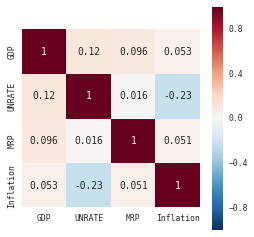

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(factors_corr, square=True, annot=True)

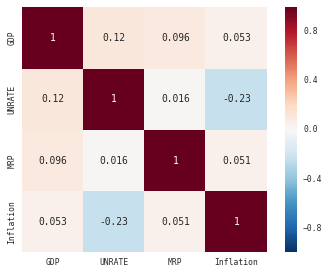

In [106]:
sns.heatmap(factors_corr, square=True, annot=True)

# Plot Cubic Spline Graph

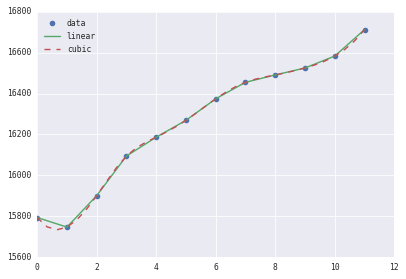

In [79]:
x = [x for x in range(len(list(GDP_df.index)))]
y = GDP_df.GDPC1
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(0, 11, num=34, endpoint=True)

a = f(xnew)
b=  temp(dates,a,'GDP',-4)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

# Get Portfolio Returns, St. Dev, SR

In [100]:
info = {'E[R_p]':portfolio_returns.mean(), 'sigma_p':portfolio_returns.std()}
df = pd.DataFrame(info)
df['Sharpe'] = df['E[R_p]'] / df['sigma_p']
df[['E[R_p]','sigma_p']].applymap('{:,.2f}%'.format)

#df['E[R_p]'] = df['E[R_p]'].map('{:,.2f}%'.format)
#df['sigma_p'] = df['sigma_p'].map('{:,.2f}%'.format)
df

,E[R_p],sigma_p,Sharpe
Portfolio_Returns,0.042281,0.063314,0.667799


# Cubic Spline Example

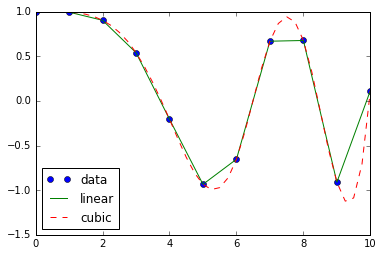

In [111]:
from scipy.interpolate import interp1d
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(0, 10, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()